In [182]:
%matplotlib ipympl 

import matplotlib.pyplot as plt
from ipywidgets import interact

from IPython.display import display, HTML
import numpy as np
import cv2

import tritonclient.http

In [183]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    

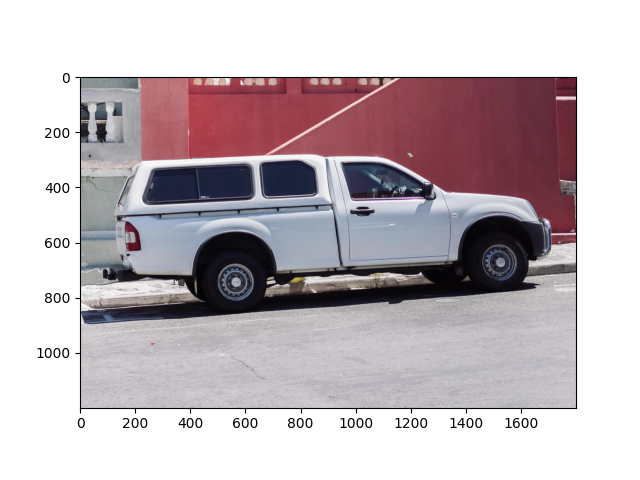

In [184]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create figure and axis
fig, ax = plt.subplots()

# Display image on axis
ax.imshow(image)

# Define function to get mouse coordinates
def onclick(event):
    # Get x and y coordinates of mouse click
    x, y = event.xdata, event.ydata
    if event.button == 1:
        # Store clicked coordinates in positive coords
        pos_coords.append((int(x), int(y)))
        ax.plot(int(x), int(y), 'go')
        print(f"set positive point at x={int(x)}, y={int(y)}")
    elif event.button == 3:
        # Store clicked coordinates in negative coords
        neg_coords.append((int(x), int(y)))
        ax.plot(int(x), int(y), 'ro')
        print(f"set negative point at x={int(x)}, y={int(y)}")

# Connect function to mouse click event
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Store clicked coordinates
pos_coords = []
neg_coords = []

# Display interactive plot
plt.show()

In [185]:
# model
model_name = "sam_stable_diffusion_inpaint"
url = "<your http ip>:<port>"
model_version = "1" 
batch_size = 1

In [194]:
# model input params
prompt = "toy story car, high quality"
negative_prompt = "None" # replace NONE with actual negative prompt if any
samples = 1 # no.of images to generate
steps = 100
guidance_scale = 7.5
seed = 1024

pos_coords = np.array(pos_coords)

if neg_coords == []:
    neg_coords = np.zeros([1, 2])
else:
    neg_coords = np.array(neg_coords)

/tmp/ipykernel_6318/3713740298.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if neg_coords == []:


In [195]:
triton_client = tritonclient.http.InferenceServerClient(url=url, verbose=False)

In [196]:
assert triton_client.is_model_ready(
    model_name=model_name, model_version=model_version
), f"model {model_name} not yet ready"

In [197]:
model_metadata = triton_client.get_model_metadata(model_name=model_name, model_version=model_version)
model_config = triton_client.get_model_config(model_name=model_name, model_version=model_version)

In [198]:
# Input placeholder
prompt_in = tritonclient.http.InferInput(name="PROMPT", shape=(batch_size,), datatype="BYTES")
negative_prompt_in = tritonclient.http.InferInput(name="NEGATIVE_PROMPT", shape=(batch_size,), datatype="BYTES")
samples_in = tritonclient.http.InferInput("SAMPLES", (batch_size, ), "INT32")
steps_in = tritonclient.http.InferInput("STEPS", (batch_size, ), "INT32")
guidance_scale_in = tritonclient.http.InferInput("GUIDANCE_SCALE", (batch_size, ), "FP32")
seed_in = tritonclient.http.InferInput("SEED", (batch_size, ), "INT64")
pos_coords_in = tritonclient.http.InferInput("POS_COORDS", pos_coords.shape, "INT64")
neg_coords_in = tritonclient.http.InferInput("NEG_COORDS", neg_coords.shape, "INT64")

image_in = tritonclient.http.InferInput("IMAGE", image.shape, "UINT8")

images = tritonclient.http.InferRequestedOutput(name="IMAGES", binary_data=False)


In [199]:
prompt_in.set_data_from_numpy(np.asarray([prompt] * batch_size, dtype=object))
negative_prompt_in.set_data_from_numpy(np.asarray([negative_prompt] * batch_size, dtype=object))
samples_in.set_data_from_numpy(np.asarray([samples], dtype=np.int32))
steps_in.set_data_from_numpy(np.asarray([steps], dtype=np.int32))
guidance_scale_in.set_data_from_numpy(np.asarray([guidance_scale], dtype=np.float32))
seed_in.set_data_from_numpy(np.asarray([seed], dtype=np.int64))
pos_coords_in.set_data_from_numpy(pos_coords.astype(np.int64))
neg_coords_in.set_data_from_numpy(neg_coords.astype(np.int64))
image_in.set_data_from_numpy(image.astype(np.uint8))


response = triton_client.infer(
    model_name=model_name, model_version=model_version, 
    inputs=[prompt_in, negative_prompt_in, samples_in, steps_in, guidance_scale_in, seed_in, pos_coords_in, neg_coords_in, image_in], 
    outputs=[images]
)

In [200]:
result = response.as_numpy("IMAGES").squeeze()

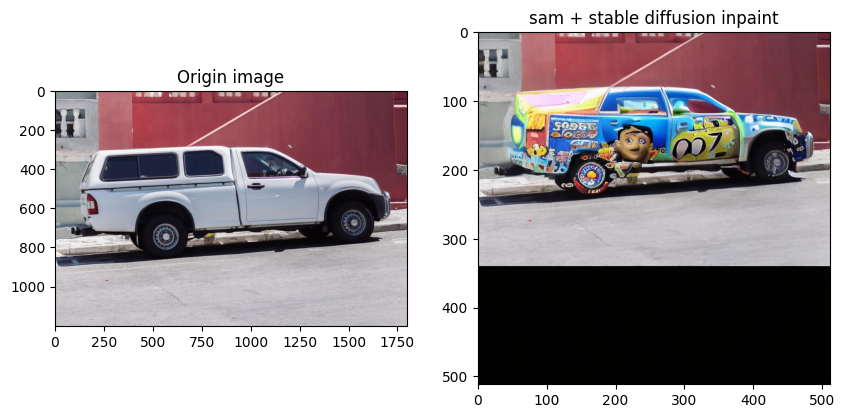

In [201]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Create a figure with two subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the first image on the left subplot
axs[0].imshow(image)
axs[0].set_title('Origin image')

# Plot the second image on the right subplot
axs[1].imshow(result)
axs[1].set_title('sam + stable diffusion inpaint')

# Show the figure
plt.show()
